# STK player bot detector with SageMaker Linear Regression - Logistic Regression


We'll look at a cool video game example where we're looking for cheaters, e.g., players who write bots to play on their behalf or coordinate with other players to gain advantage over legitimate players. We'll show which ML models can detect these cheats and how to run the analysis from the customer application using SQL. The scenario we simulate is a successful multiplayer game you launched few months ago on AWS. The game is fun, but the customer care team recently received many complaints about players cheating in the game. The task is to catch the cheaters and remove them from the game. You need to build a cheat detection system that will extend the customer-care application to hint with good efficacy about cheaters to improve the playing experience. We assume the customer care application uses Aurora MySQL, so you would like to minimize the changes to the application and use Aurora MySQL tools to detect the cheaters. 

We assume thegame server (https://github.com/aws-samples/amazon-aurora-call-to-amazon-sagemaker-sample/tree/master/stk-sample/env-build/eks) runs in Elastic Kubernetes Service and streams the server stdout to Kinesis Firehose using Fluentbit (https://fluentbit.io/) project. Kinesis Firehose stores the player actions in S3 that loads (https://github.com/aws-samples/amazon-aurora-call-to-amazon-sagemaker-sample/tree/master/stk-sample/env-build/lambda/stk-player-events-loader) in bulks the data to Aurora table actions. 
The game play actions defined as the struct Action. 

```
struct Action
    {
        int          m_ticks;
        int          m_kart_id;
        PlayerAction m_action;
        int          m_value;
        int          m_value_l;
        int          m_value_r;
    }; 
```

The game server emits player game actions logs in near real-time as the game progressed. m_ticks is a counter that increments upon any player action. m_kart_id is the player kart unique id. The m_value, m_value_l, and m_value_r indicates the action magnitude e.g., when player attempt to slow down abruptly, the brake action carries the max integer 32768. Similarly for accelerating and kart steer.

```
+-----------+--------------+------+-----+---------+----------------+
| Field     | Type         | Null | Key | Default | Extra          |
+-----------+--------------+------+-----+---------+----------------+
| id        | mediumint(9) | NO   | PRI | NULL    | auto_increment |
| m_ticks   | double | YES |      | NUL |         |
| m_kart_id | double | YES |      | NUL |         |
| m_action  | double | YES |      | NUL |         |
| m_value   | double | YES |      | NUL |         |
| m_value_l | double | YES |      | NUL |         |
| m_value_r | double | YES |      | NUL |         |
| class     | int(11)| YES |      | NUL |         |
+-----------+--------------+------+-----+---------+----------------+
```

We facilitated hundreds of legitimate multiplayer game sessions and bot simulated game sessions. Game sessions were manually classified by updating sequence of player actions after the game session. e.g., we captured the last game sequence id prior the game session and updated the class value with 1 in the case of bot simulated session or 0 in the case of legitimate game session. e.g. update actions set class=1 where id>Num and class is null

## Formulating the ML problem

The game we use is SuperTuxKart, a free and open-source kart racing game.
Players take actions during the game like collecting and using cans of Nitro. Players also use of various power-up (https://en.wikipedia.org/wiki/Power-up) items obtained by driving into item boxes laid out on the course. These power-ups include mushrooms (https://en.wikipedia.org/wiki/Super_Mario_(series)#Mushrooms) to give players a speed boost, Koopa (https://en.wikipedia.org/wiki/Koopa_Troopa) Shells to be thrown at opponents, and banana peels (https://en.wikipedia.org/wiki/Banana_peel) and fake item boxes that can be laid on the course as hazards.  
Player actions (https://github.com/supertuxkart/stk-code/blob/master/src/input/input.hpp) are defined as a collection of game actions such as kart steer, brake, drift, look back etc. Cheating allows bots to benefit from power-up items while steering or braking the karts. Below we will classify the player behavior and distinct between human and bot actions. We will classify the suspicious player actions and then cross-reference it with other customer records already stored in the application database schema. e.g., customer care application that stores players' records in-game micro-transactions and customer care events. Therefore, we will train two models. The first is tracking bots by player moves and the second is to detect suspicious in-game micro-transactions.

The rest of the notebook Implements the data exploration, preparation, model trainning, deployments and testing. 

#### Install packages

In [283]:
%%bash 
home=`pwd`
. $home/env
pip3 install mysql-connector-python

bash: line 2: /home/ec2-user/SageMaker/amazon-aurora-call-to-amazon-sagemaker-sample/stk-sample/env-build/sagemaker/env: No such file or directory
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [284]:
import sagemaker
execution_role = sagemaker.get_execution_role()
print(execution_role)

arn:aws:iam::163538056407:role/service-role/AmazonSageMaker-ExecutionRole-20200913T212219


## Data Exploration

In [506]:
%%time

import json
import boto3
import csv
import mysql.connector
import sys
import os
import configparser

config = configparser.ConfigParser()

config.read('rds.ini')

ENDPOINT=config['default']['ENDPOINT']
USR=config['default']['USR']
PASWD=config['default']['PASWD']
REGION=config['default']['REGION']
DBNAME=config['default']['DBNAME']

client = boto3.client('rds')

CPU times: user 6.71 ms, sys: 0 ns, total: 6.71 ms
Wall time: 5.96 ms


Getting the right size of the grouping

In [286]:
%%time
import pandas as pd

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
    
  cur.execute("""select id,c_v,vel,vel_l,vel_r,class from v_actions_m_value_velocity where class=0 and party_size=2""")
  human_vel_m_value_list=cur.fetchall()
    
  cur.execute("""select id,c_v,vel,vel_l,vel_r,class from v_actions_m_value_velocity where class=1 and party_size=2""")
  bot_vel_m_value_list=cur.fetchall()  

  cur.execute("""select id,accel,accel_l,accel_r,class from v_actions_m_value_accel where class=0 and party_size=2""")
  human_accel_m_value_list=cur.fetchall()
    
  cur.execute("""select id,accel,accel_l,accel_r,class from v_actions_m_value_accel where class=1 and party_size=2""")
  bot_accel_m_value_list=cur.fetchall()
    
  cur.execute("""select id,c_t,vel,class from v_actions_ticks_velocity where class=0""")
  human_vel_ticks_list=cur.fetchall()
    
  cur.execute("""select id,c_t,vel,class from v_actions_ticks_velocity where class=1""")
  bot_vel_ticks_list=cur.fetchall()
    
  cur.execute("""select id,accel,class from v_actions_ticks_accel where class=0""")
  human_accel_ticks_list=cur.fetchall()
    
  cur.execute("""select id,accel,class from v_actions_ticks_accel where class=1""")
  bot_accel_ticks_list=cur.fetchall()
    
except Exception as e:
  print("Database connection failed due to {}".format(e))

CPU times: user 42.8 ms, sys: 0 ns, total: 42.8 ms
Wall time: 434 ms


### Investigate and process the data

In [287]:
import pandas as pd

human_vel_m_value=pd.DataFrame(human_vel_m_value_list)
bot_vel_m_value=pd.DataFrame(bot_vel_m_value_list)

human_vel_m_value.rename(columns={0:'id',
                            1:'c_v',
                            2:'vel',
                            3:'vel_l',
                            4:'vel_r',
                            5:'class'
                           }, 
                 inplace=True)
bot_vel_m_value.rename(columns={0:'id',
                            1:'c_v',
                            2:'vel',
                            3:'vel_l',
                            4:'vel_r',
                            5:'class'
                           }, 
                 inplace=True)


human_accel_m_value=pd.DataFrame(human_accel_m_value_list)
bot_accel_m_value=pd.DataFrame(bot_accel_m_value_list)

human_accel_m_value.rename(columns={0:'id',
                            1:'accel',
                            2:'accel_l',
                            3:'accel_r',
                            4:'class'
                           }, 
                 inplace=True)
bot_accel_m_value.rename(columns={0:'id',
                            1:'accel',
                            2:'accel_l',
                            3:'accel_r',
                            4:'class'
                           }, 
                 inplace=True)


human_vel_ticks=pd.DataFrame(human_vel_ticks_list)
bot_vel_ticks=pd.DataFrame(bot_vel_ticks_list)

human_vel_ticks.rename(columns={0:'id',
                            1:'c_t',
                            2:'vel',
                            3:'class'
                           }, 
                 inplace=True)
bot_vel_ticks.rename(columns={0:'id',
                            1:'c_t',
                            2:'vel',
                            3:'class'
                           }, 
                 inplace=True)


human_accel_ticks=pd.DataFrame(human_accel_ticks_list)
bot_accel_ticks=pd.DataFrame(bot_accel_ticks_list)

human_accel_ticks.rename(columns={0:'id',
                            1:'accel',
                            2:'class'
                           }, 
                 inplace=True)
bot_accel_ticks.rename(columns={0:'id',
                            1:'accel',
                            2:'class'
                           }, 
                 inplace=True)

### Let's look for interesting data patterns
#### first look at player ticks 

The game simulates car's motions that move at a dynamic acceleration along a non-straight line. We can use fundamental kinematic physics to calculate the average velocity and acceleration changes and train a linear regression-based model that predicts bot or human kart velocity and acceleration.
We found that the values of the actions generated by bot distributed differently than the human player. We attribute the findings to a naively written bot, but the methodology we propose is not limited to the bot implementation. This behavior can be attributed to the specific player level that tends to generate more hectic action values than a bot that knows the right path to take.

Lets first calculate the player actions velocity, vel in a session for bot and human `(prev.class=curr.class)` as follow:

```sql
create or replace view v_actions_m_value_velocity as
select id,m_action,m_kart_id,c_v,p_v,(c_v-p_v) vel,c_v_l,p_v_l,(c_v_l-p_v_l) vel_l,c_v_r,p_v_r,(c_v_r-p_v_r) vel_r,party_size,session,class
from
(
select curr.id,curr.m_action,curr.m_kart_id,curr.m_value c_v,prev.m_value p_v,curr.m_value_l c_v_l,prev.m_value_l p_v_l,curr.m_value_r c_v_r,prev.m_value_r p_v_r,curr.party_size,curr.session,curr.class
from actions prev, actions curr
where prev.id=curr.id-1 and prev.class=curr.class and curr.m_kart_id=prev.m_kart_id and curr.m_action=prev.m_action and curr.party_size=prev.party_size and curr.session=prev.session and party_size=2
order by curr.m_kart_id,curr.id
) v

create or replace view v_actions_m_value_accel as
select id,m_action,m_kart_id,c_v,p_v,c_vel,p_vel,(c_vel-p_vel) accel,c_v_l,p_v_l,c_vel_l,p_vel_l,(c_vel_l-p_vel_l) accel_l,c_v_r,p_v_r,c_vel_r,p_vel_r,(c_vel_r-p_vel_r) accel_r,party_size,session,class
from
(
select curr.id,curr.m_action,curr.m_kart_id,curr.c_v,curr.p_v,curr.vel c_vel,prev.vel p_vel,curr.c_v_l,curr.p_v_l,curr.vel_l c_vel_l,prev.vel_l p_vel_l,curr.c_v_r,curr.p_v_r,curr.vel_r c_vel_r,prev.vel_r p_vel_r,curr.party_size,curr.session,curr.class
  from v_actions_m_value_velocity prev,v_actions_m_value_velocity curr
  where prev.id=curr.id-1 and prev.class=curr.class and curr.m_kart_id=prev.m_kart_id and curr.m_action=prev.m_action and curr.party_size=prev.party_size and curr.session=prev.session and curr.party_size=2
  order by curr.m_kart_id,curr.id
) v
```

We are going to look for patterns in the velocity and acceleration rates

In [288]:
import matplotlib.pyplot as plt
import pandas as pd

id       1372
c_t      1372
vel      1372
class    1372
dtype: int64


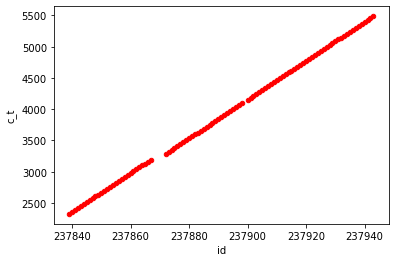

In [289]:
print(bot_vel_ticks.count())
bot_vel_ticks[100:200].plot(kind='scatter',x='id',y='c_t',color='red')
plt.show()

id       5140
c_t      5140
vel      5140
class    5140
dtype: int64


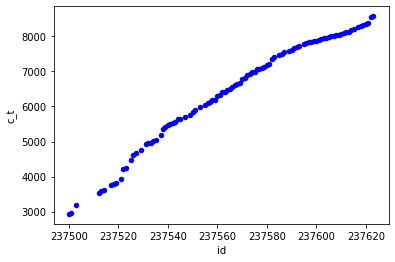

In [290]:
print(human_vel_ticks.count())
human_vel_ticks[100:200].plot(kind='scatter',x='id',y='c_t',color='blue')
plt.show()

id       1250
accel    1250
class    1250
dtype: int64


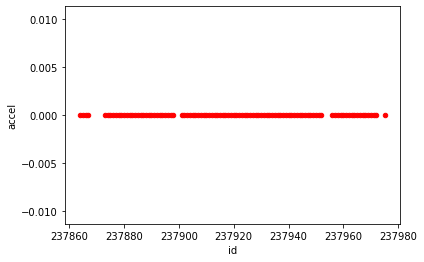

In [291]:
print(bot_accel_ticks.count())
bot_accel_ticks[100:200].plot(kind='scatter',x='id',y='accel',color='red')
plt.show()

id       2034
accel    2034
class    2034
dtype: int64


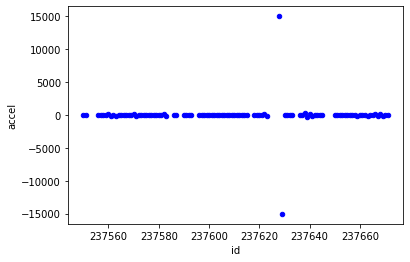

In [292]:
print(human_accel_ticks.count())
human_accel_ticks[100:200].plot(kind='scatter',x='id',y='accel',color='blue')
plt.show()

We can see different patterns for `m_ticks` in bot and human. But `m_ticks` average velocity and acceleration seems to be similar so we need to look for more patterns. Lets look at `m_values` of those player ticks. Specifically for `actions=0 or 1`

id       4721
c_v      4721
vel      4721
vel_l    4721
vel_r    4721
class    4721
dtype: int64
Index(['id', 'c_v', 'vel', 'vel_l', 'vel_r', 'class'], dtype='object')


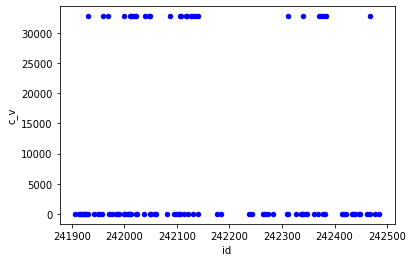

In [293]:
print(human_vel_m_value.count())
print(human_vel_m_value.columns)
human_vel_m_value[100:200].plot(kind='scatter',x='id',y='c_v',color='blue')
plt.show()

id       198
c_v      198
vel      198
vel_l    198
vel_r    198
class    198
dtype: int64
Index(['id', 'c_v', 'vel', 'vel_l', 'vel_r', 'class'], dtype='object')


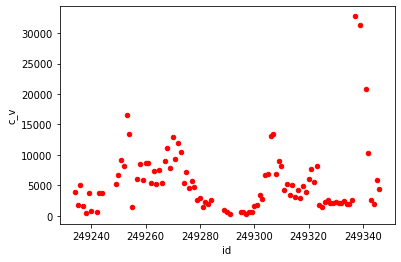

In [294]:
print(bot_vel_m_value.count())
print(bot_vel_m_value.columns)
bot_vel_m_value[100:200].plot(kind='scatter',x='id',y='c_v',color='red')
plt.show()

We can see the bot `m_value` distrubition is different than human. Lets see the average velocity changes. 

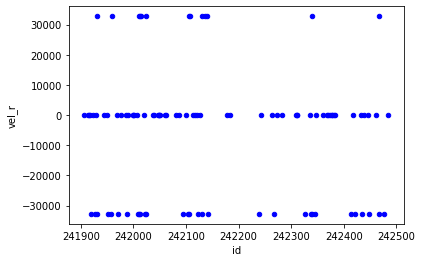

Index(['id', 'c_v', 'vel', 'vel_l', 'vel_r', 'class'], dtype='object')

In [295]:
human_vel_m_value[100:200].plot(kind='scatter',x='id',y='vel_r',color='blue')
plt.show()
human_vel_m_value.columns

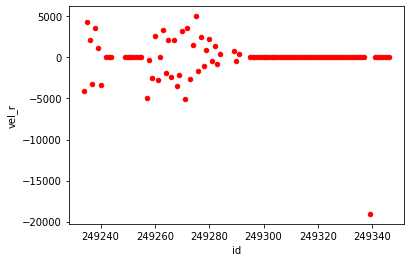

Index(['id', 'c_v', 'vel', 'vel_l', 'vel_r', 'class'], dtype='object')

In [296]:
bot_vel_m_value[100:200].plot(kind='scatter',x='id',y='vel_r',color='red')
plt.show()
bot_vel_m_value.columns

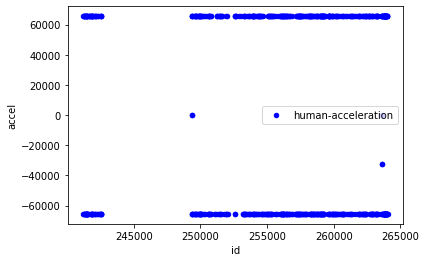

Index(['id', 'accel', 'accel_l', 'accel_r', 'class'], dtype='object')

In [297]:
human_accel_m_value[600:2500].plot(kind='scatter',x='id',y='accel', label='human-acceleration',color='blue')
plt.show()
human_accel_m_value.columns

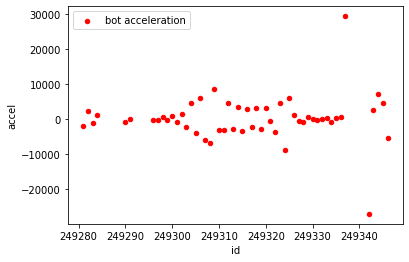

Index(['id', 'accel', 'accel_l', 'accel_r', 'class'], dtype='object')

In [298]:
bot_accel_m_value[100:1500].plot(kind='scatter',x='id',y='accel',label='bot acceleration',color='red')
plt.show()
bot_accel_m_value.columns

## Data preparation 

Alright, enough with the graphs, we noticed `m_value` and its `accel` as well as `m_value_l` and `m_value_r` and its `accel_l`, `accel_r` behave diffrently for `party_size=2`. lets build a data structure that includes these fields. 

In [496]:
%%time
import pandas as pd

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
    
  cur.execute("""select class,m_action,
                  c_v value,c_vel velocity,accel,
                  c_v_l value_l,c_vel_l velocity_l,accel_l,
                  c_v_r value_r,c_vel_r velocity_r,accel_r
                 from v_actions_m_value_accel where party_size=2""")
  actions_m_value_accel_list=cur.fetchall()
    
except Exception as e:
  print("Database connection failed due to {}".format(e))


actions_m_value_accel=pd.DataFrame(actions_m_value_accel_list)

actions_m_value_accel.rename(columns={
                            0:'class',
                            1:'m_action',
                            2:'value',
                            3:'velocity',
                            4:'accel',
                            5:'value_l',
                            6:'velocity_l',
                            7:'accel_l',
                            8:'value_r',
                            9:'velocity_r',
                           10:'accel_r'
                           }, 
                 inplace=True)
actions_m_value_accel.groupby('class').size()

CPU times: user 27 ms, sys: 0 ns, total: 27 ms
Wall time: 174 ms


class
0    1264
1     153
dtype: int64

### Encoding the categorical feature m_action 

In [497]:
from numpy import argmax
from numpy import array
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
actions_m_value_accel_array=array(actions_m_value_accel.m_action)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(actions_m_value_accel_array)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

print('sample of the one hot encoding {}'.format(onehot_encoded[10]))
print('the length of the m_action onehot encoding is {}'.format(len(onehot_encoded)))
onehot_encoded.shape

sample of the one hot encoding [1. 0. 0. 0. 0. 0. 0.]
the length of the m_action onehot encoding is 1417


(1417, 7)

Preparing the `actions_m_value_accel` dataframe with the 7xn encoded `m_action` array.

* Removing the `m_action` column
* Convert the `actions_m_value_accel` to array 
* Append the 7xn `onehot_encoded` array with `actions_m_value_accel_arr` 

In [494]:
print(actions_m_value_accel.columns)
actions_m_value_accel=actions_m_value_accel.drop(columns=['m_action'])
print(actions_m_value_accel.columns)
actions_m_value_accel_arr=array(actions_m_value_accel)
print("actions_m_value_accel_arr.shape="+str(actions_m_value_accel_arr.shape))
all_data = numpy.append(actions_m_value_accel_arr, onehot_encoded, 1)
all_data.shape

Index(['class', 'm_action', 'value', 'velocity', 'accel', 'value_l',
       'velocity_l', 'accel_l', 'value_r', 'velocity_r', 'accel_r'],
      dtype='object')
Index(['class', 'value', 'velocity', 'accel', 'value_l', 'velocity_l',
       'accel_l', 'value_r', 'velocity_r', 'accel_r'],
      dtype='object')
actions_m_value_accel_arr.shape=(1417, 10)


(1417, 17)

Create a mapping table between player `m_action` and the onehotencoding used for training
```
create table if not exists m_action_encoding (
  m_action int,
  i_0 int,
  i_1 int,
  i_2 int,
  i_3 int,
  i_4 int,
  i_5 int,
  i_6 int
);
```


In [507]:
m_action_encoded_dict={}
#dedup m_action_encoded
for i in range(0,len(onehot_encoded),1):
    key=str(onehot_encoded[i])+';'+str(integer_encoded[i])
    m_action_encoded_dict[key]=1
   
values=''    
for j in m_action_encoded_dict:
    m_action_encode=j.split(';')
    m_action_onehot=m_action_encode[0].replace('[','').replace(']','').split()
    m_action_int=m_action_encode[1].replace('[','').replace(']','')
    #print('{},{}'.format(m_action_onehot,m_action_int))
    i_0=m_action_onehot[0]
    i_1=m_action_onehot[1]
    i_2=m_action_onehot[2]
    i_3=m_action_onehot[3]
    i_4=m_action_onehot[4]
    i_5=m_action_onehot[5]
    i_6=m_action_onehot[6]
    value='('+m_action_int+','+i_0+','+i_1+','+i_2+','+i_3+','+i_4+','+i_5+','+i_6+')'
    if(values):
      values=values+','+value
    else:
      values=value
    
#print('values = {}'.format(values))
insert_stmt=(
  "INSERT INTO m_action_encoding(m_action,i_0,i_1,i_2,i_3,i_4,i_5,i_6)"
  " VALUES "+values
)    
print('insert_stmt = {}'.format(insert_stmt))

try:
    conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
    cur = conn.cursor()
    cur.execute('DELETE FROM m_action_encoding')
    cur.execute(insert_stmt)
    conn.commit()
except Exception as e:
    print("Database connection failed due to {}".format(e))


insert_stmt = INSERT INTO m_action_encoding(m_action,i_0,i_1,i_2,i_3,i_4,i_5,i_6) VALUES (1,0.,1.,0.,0.,0.,0.,0.),(0,1.,0.,0.,0.,0.,0.,0.),(3,0.,0.,0.,1.,0.,0.,0.),(2,0.,0.,1.,0.,0.,0.,0.),(5,0.,0.,0.,0.,0.,1.,0.),(6,0.,0.,0.,0.,0.,0.,1.),(4,0.,0.,0.,0.,1.,0.,0.)


In [512]:
df=pd.DataFrame(all_data) 
df.head()
df.rename(columns={
                    0:'class',
                    1:'value',
                    2:'velocity',
                    3:'accel',
                    4:'value_l',
                    5:'velocity_l',
                    6:'accel_l',
                    7:'value_r',
                    8:'velocity_r',
                    9:'accel_r',
                    10:'m_action_0',
                    11:'m_action_1',
                    12:'m_action_2',
                    13:'m_action_3',
                    14:'m_action_4',
                    15:'m_action_5',
                    16:'m_action_6'
                }, 
                 inplace=True)

In [522]:
df.columns

Index(['class', 'value', 'velocity', 'accel', 'value_l', 'velocity_l',
       'accel_l', 'value_r', 'velocity_r', 'accel_r', 'm_action_0',
       'm_action_1', 'm_action_2', 'm_action_3', 'm_action_4', 'm_action_5',
       'm_action_6'],
      dtype='object')

In [514]:
df.head()

,class,value,velocity,accel,value_l,velocity_l,accel_l,value_r,velocity_r,accel_r,m_action_0,m_action_1,m_action_2,m_action_3,m_action_4,m_action_5,m_action_6
0,0.0,32768.0,32768.0,65536.0,0.0,0.0,0.0,0.0,32768.0,65536.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-32768.0,-65536.0,0.0,0.0,0.0,-32768.0,-32768.0,-65536.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,32768.0,32768.0,65536.0,0.0,0.0,0.0,0.0,32768.0,65536.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-32768.0,-65536.0,0.0,0.0,0.0,-32768.0,-32768.0,-65536.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,32768.0,32768.0,65536.0,0.0,0.0,0.0,0.0,32768.0,65536.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [523]:
df.columns[1:17]

Index(['value', 'velocity', 'accel', 'value_l', 'velocity_l', 'accel_l',
       'value_r', 'velocity_r', 'accel_r', 'm_action_0', 'm_action_1',
       'm_action_2', 'm_action_3', 'm_action_4', 'm_action_5', 'm_action_6'],
      dtype='object')

In [524]:
df.columns[0]

'class'

## Build a model - m_value velocity and acceleration

In [525]:
feature_columns = df.columns[1:17]
label_column = df.columns[0]

print('feature_columns={}'.format(feature_columns))
print('label_column={}'.format(label_column))

features = df[feature_columns].values.astype('float32')
labels = (df[label_column].values).astype('float32')
print(features[3])
labels[3]

feature_columns=Index(['value', 'velocity', 'accel', 'value_l', 'velocity_l', 'accel_l',
       'value_r', 'velocity_r', 'accel_r', 'm_action_0', 'm_action_1',
       'm_action_2', 'm_action_3', 'm_action_4', 'm_action_5', 'm_action_6'],
      dtype='object')
label_column=class
[ 0.0000e+00 -3.2768e+04 -6.5536e+04  0.0000e+00  0.0000e+00  0.0000e+00
 -3.2768e+04 -3.2768e+04 -6.5536e+04  0.0000e+00  1.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]


0.0

In [526]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features, labels)
buf.seek(0);

In [527]:
import boto3
import os
import sagemaker

session = sagemaker.Session()
bucket = 'stk-events'

prefix = 'bot-detect-ticks-model'
key = 'recordio-pb-data'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://stk-events/bot-detect-ticks-model/train/recordio-pb-data
Training artifacts will be uploaded to: s3://stk-events/bot-detect-ticks-model/output


In [528]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

from sagemaker import get_execution_role

linear = sagemaker.estimator.Estimator(container,
                                       get_execution_role(), 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=features.shape[1],
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data},wait=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [ ]:
#delete old endpoint
sagemaker.Session().delete_endpoint("stk-bot-detect-actions")

In [532]:
from sagemaker.predictor import csv_serializer, json_deserializer


linear_predictor = linear.deploy(initial_instance_count=1,
                                 endpoint_name='stk-bot-detect-actions',
                                 instance_type='ml.c4.large')
# Specify input and output formats.
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer
print('Endpoint name: {}'.format(linear_predictor.endpoint))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!Endpoint name: stk-bot-detect-actions


Lets test the model with existing data. Pull classified data and see if the model predicted the correct classification. e.g., calls with `where class=1` returns `'predicted_label': 1` 

Another way is to let two players play the game, wait two minutes for the game events to stream to Aurora and look for events with `class is null` instead of `class=1` or `class=0`

In [562]:
%%time
import pandas as pd

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""
    SELECT c_v,c_vel,accel,c_v_l,c_vel_l,accel_l,c_v_r,c_vel_r,accel_r,
          t2.i_0,t2.i_1,t2.i_2,t2.i_3,t2.i_4,t2.i_5,t2.i_6 
    FROM v_actions_m_value_accel t1,m_action_encoding t2 
    WHERE t1.m_action=t2.m_action and class=1
    LIMIT 3
              """)
  result_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))
#sample=''.join(sample_list[0])

CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 94.3 ms


In [563]:
for sample in result_list:
    print(sample)
    ret=linear_predictor.predict(sample)
    print(ret)

(924.0, 87.0, 34.0, 837.0, 53.0, -101.0, 0.0, 0.0, 0.0, 1, 0, 0, 0, 0, 0, 0)
{'predictions': [{'score': 0.9363782405853271, 'predicted_label': 1}]}
(588.0, -336.0, -423.0, 924.0, 87.0, 34.0, 0.0, 0.0, 0.0, 1, 0, 0, 0, 0, 0, 0)
{'predictions': [{'score': 0.9387953877449036, 'predicted_label': 1}]}
(534.0, -54.0, 282.0, 588.0, -336.0, -423.0, 0.0, 0.0, 0.0, 1, 0, 0, 0, 0, 0, 0)
{'predictions': [{'score': 0.9430064558982849, 'predicted_label': 1}]}


### Clean up


We will leave the prediction endpoint running at the end of this notebook so we can handle incoming event streams. However, don't forget to delete the prediction endpoint when you're done. You can do that at the Amazon SageMaker console in the Endpoints page. Or you can run linear_predictor.delete_endpoint()